<a href="https://colab.research.google.com/github/OCanSagbas/AI-DataScience/blob/main/HouseValuePredictionwithSpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler

#Gerekli kütüphanelerin indirilmesi

In [ ]:
from pyspark.sql import SparkSession
# SparkSession oluşturma kısmı
spark = SparkSession.builder \
    .appName("SparkSession") \
    .getOrCreate()

In [ ]:
csv = spark.read.csv('/content/housing.csv', inferSchema=True, header=True)
csv.show()
#Gerekli dataların okunma kısmı

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

In [ ]:
null_counts = csv.select([count(when(isnull(c), c)).alias(c) for c in csv.columns])
null_counts.show()
#Verilerde olan null değerleri görüp listeledim.

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|        0|       0|                 0|          0|           207|         0|         0|            0|                 0|              0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+



In [ ]:
csv = csv.drop("total_bedrooms")
csv.show()
#Null değerlere sahip olan total_bedrooms feature özelliğini kaldırdım.

+---------+--------+------------------+-----------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1627.0|     565.0|     259.0|       3.8462|          342200.0|       NEAR BAY|
|  -122.25|   37

In [ ]:
csv.describe().show()

+-------+-------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------+
|summary|          longitude|         latitude|housing_median_age|       total_rooms|        population|       households|     median_income|median_house_value|ocean_proximity|
+-------+-------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------+
|  count|              20640|            20640|             20640|             20640|             20640|            20640|             20640|             20640|          20640|
|   mean|-119.56970445736148| 35.6318614341087|28.639486434108527|2635.7630813953488|1425.4767441860465|499.5396802325581|3.8706710029070246|206855.81690891474|           NULL|
| stddev|  2.003531723502584|2.135952397457101| 12.58555761211163|2181.6152515827944|  1132.46212176534|382.3297528

In [ ]:
splits = csv.randomSplit([0.7, 0.3])
train = splits[0]
test = splits[1]
train_rows = train.count()
test_rows = test.count()
print("Training Rows:", train_rows, " Testing Rows:", test_rows)
#Verileri train ve test olarak %70'e %30 olarak ayırdım.

Training Rows: 14401  Testing Rows: 6239


In [ ]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor

strId = StringIndexer(inputCol = "ocean_proximity", outputCol = "ocean_proximityID")
HousingVect = VectorAssembler(inputCols = ["longitude","latitude","housing_median_age","total_rooms","population","households","median_income","ocean_proximityID"], outputCol="FeaturesOfHousingPrice")
# scaler = MinMaxScaler(inputCol="FeaturesOfHousingPrice", outputCol="FeaturesOfHousingPriceScaled")
dt = RandomForestRegressor(labelCol="median_house_value", featuresCol="FeaturesOfHousingPrice")
pipeline = Pipeline(stages=[strId, HousingVect,dt])
#Burada pipeline oluşturdum. içinde ocean_proximity'i sayısal veriye çevirdim 0,1,2 şeklinde
#Tek bir column'a taşıdım. MinMax denedim ancak RMSE değerini çok etkilemediği için kaldırdım.

In [ ]:
pipelineModel = pipeline.fit(train)
print("Pipeline complete!")
train_performance = pipelineModel.transform(train)
train_performance.select("FeaturesOfHousingPrice", "median_house_value").show(truncate=False)
#Pipeline modeli önce fit edip ardından train setine transform ettim.

Pipeline complete!
+---------------------------------------------------+------------------+
|FeaturesOfHousingPrice                             |median_house_value|
+---------------------------------------------------+------------------+
|[-124.35,40.54,52.0,1820.0,806.0,270.0,3.0147,2.0] |94600.0           |
|[-124.3,41.8,19.0,2672.0,1298.0,478.0,1.9797,2.0]  |85800.0           |
|[-124.3,41.84,17.0,2677.0,1244.0,456.0,3.0313,2.0] |103600.0          |
|[-124.26,40.58,52.0,2217.0,907.0,369.0,2.3571,2.0] |111400.0          |
|[-124.25,40.28,32.0,1430.0,434.0,187.0,1.9417,2.0] |76100.0           |
|[-124.23,40.54,52.0,2694.0,1152.0,435.0,3.0806,2.0]|106700.0          |
|[-124.23,40.81,52.0,1112.0,544.0,172.0,3.3462,2.0] |50800.0           |
|[-124.23,41.75,11.0,3159.0,1343.0,479.0,2.4805,2.0]|73200.0           |
|[-124.22,41.73,28.0,3003.0,1530.0,653.0,1.7038,2.0]|78300.0           |
|[-124.21,40.75,32.0,1218.0,620.0,268.0,1.6528,2.0] |58100.0           |
|[-124.21,41.75,20.0,3810.0,1993

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
test_performance = pipelineModel.transform(test)
# Test seti üzerinde de pipelinemodeli transform ettim

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction")
rmse_train = evaluator.evaluate(train_performance, {evaluator.metricName: "rmse"})
print("Eğitim Seti - Root Mean Squared Error (RMSE):", rmse_train)
rmse_test = evaluator.evaluate(test_performance, {evaluator.metricName: "rmse"})
print("Test Seti - Root Mean Squared Error (RMSE):", rmse_test)
# Eğitim ve test seti üzerindeki RMSE değerin sonuçlarını yazdırdım

Eğitim Seti - Root Mean Squared Error (RMSE): 67792.88453742255
Test Seti - Root Mean Squared Error (RMSE): 68653.28437138168


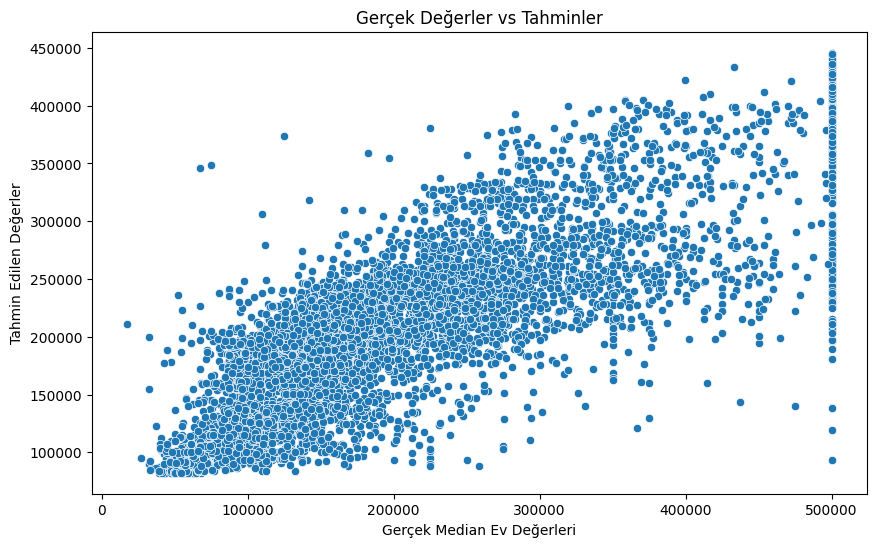

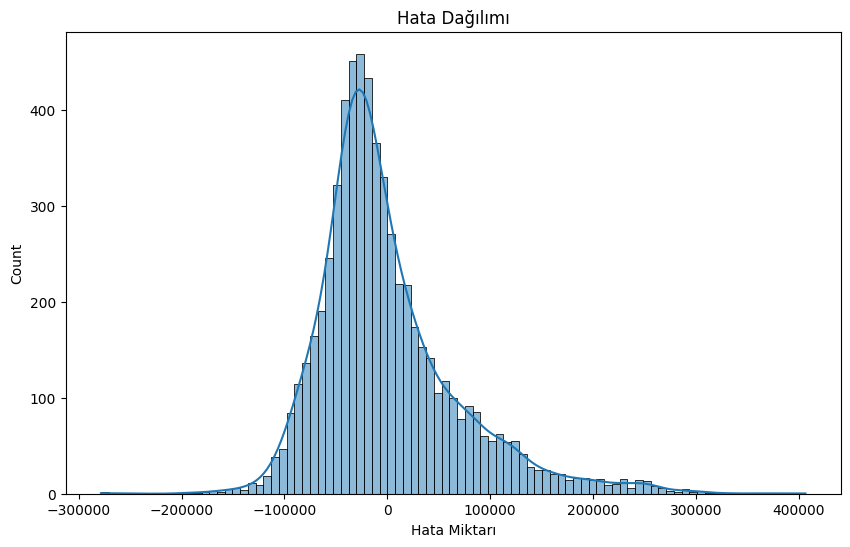

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

predictions_pd = test_performance.select("prediction", "median_house_value").toPandas()

plt.figure(figsize=(10, 6))
sns.scatterplot(x="median_house_value", y="prediction", data=predictions_pd)
plt.title("Gerçek Değerler vs Tahminler")
plt.xlabel("Gerçek Median Ev Değerleri")
plt.ylabel("Tahmin Edilen Değerler")
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(predictions_pd["median_house_value"] - predictions_pd["prediction"], kde=True)
plt.title("Hata Dağılımı")
plt.xlabel("Hata Miktarı")
plt.show()
# Ardından scatter ve histogram ile yaptığım hataların oranını görselleştirdim